<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png"/>

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>    

# Detección de mensajes sexistas con CNN

En este notebook, vamos a trabajar con el dataset de la competición [EXIST 2021](#http://nlp.uned.es/exist2021/) cuyo objetivo es la identificación de mensajes sexitas en las redes sociales. 

Este dataset ha sido anotado para las siguientes tareas:

- 1) Clasificación binaria: cada texto es clasificado como un texto con contenido sexista (sexist) o no sexista (non-sexist).
- 2) Una vez que se han clasificado los mensajes sexistas, la segunda tarea es determimar el tipo de sexismo. En particular, se proponen cinco clases: Una vez que un mensaje ha sido catalogado como sexista, la segunda tarea tiene como objetivo categorizar el mensaje según el tipo de sexismo (según la categorización propuesta por expertos y que tiene en cuenta las diferentes facetas de la mujer que se desvirtúan). En particular, proponemos una tarea de cinco clasificaciones:IDEOLOGICAL AND INEQUALITY, STEREOTYPING AND DOMINANCE, OBJECTIFICATION, SEXUAL VIOLENCE, MISOGYNY AND NON-SEXUAL VIOLENCE. Para ver una descripción más detallada de estas clases, visitar este [link](#http://nlp.uned.es/exist2021/).

En este notebook, nos centraremos únicamente en la primera tarea que consiste en una clasificación binaria de los textos. 

El datase debe solicitarse a los organizadores de la competición: jcalbornoz@lsi.uned.es, frodriguez.sanchez@invi.uned.es or lplaza@lsi.uned.es 

- The dataset should only be used for scientific or research purposes. Any other use is explicitly prohibited.
- The datasets must not be redistributed or shared in part or full to any third party. Redirect interested parties to this website.
- All data released for these tasks are under the CC BY-SA 4.0 License (https://creativecommons.org/licenses/by-sa/4.0/legalcode).
- Data must not be used for providing surveillance, analyses or research that isolates a group of individuals or any single individual for any unlawful or discriminatory purpose.




## Dataset

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/data/exist2022/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df_train = pd.read_csv(PATH+"EXIST2021_training.tsv",  sep='\t') 
df_train = df_train.drop(['test_case', 'id', 'source', 'task2'], axis=1)
df_train = df_train.rename(columns={'task1':'label'})

df_test = pd.read_csv(PATH+"EXIST2021_test.tsv",  sep='\t') 
df_test = df_test.drop(['test_case', 'id', 'source', 'task2'], axis=1)
df_test = df_test.rename(columns={'task1':'label'})
print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# df_test.head()

tamaño training: (6977, 3)
tamaño test: (4368, 3)


## Label Encoding



En el caso de clasifición binaria, solo necesitamos transformar las labels de texto a número entero:
- non-sexist -> 0
- sexist -> 1


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()

LABELS = sorted(set(y_test))
print('Conjunto de etiquetas:', LABELS)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


Conjunto de etiquetas: ['non-sexist', 'sexist']


### Tokenización

Puedes consultar más información sobre el tokenizador de keras en este [link](#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).


In [ ]:
X_train = df_train['text'].tolist()
X_test = df_test['text'].tolist()

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

from keras.utils import pad_sequences 

MAX_LEN=60

encoded_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_LEN, padding='post')


Tamaño del vocabulario =35472


## CNN

In [ ]:
import tensorflow as tf 
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)

tf.__version__

'2.9.2'

### Construir matriz de embeddings

Creamos la matriz a partir de un modelo pre-entrenado de word embeddings. Cada token (en realidad, su entero que lo representa) del vocabulario es representado con un vector del modelo de word embeddings. El proceso puede tardar unos minutos :

In [ ]:
import gensim.downloader as api
import numpy as np

model_we = api.load("glove-wiki-gigaword-50")
#model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

EMBED_SIZE = 50

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matriz creada')


matriz creada


In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE, 
                    input_length=MAX_LEN, weights=[embedding_matrix],))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# Para clasificación binaria
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 50)            1773600   
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 128)           25728     
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 64)            32832     
                                                                 
 conv1d_5 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


### Training

Como no tenemos un conjunto de validación explícito, en el método compile específicamos usando el argumento **        validation_split** qué porcentaje del training vamos a usar como conjunto de validación:

In [ ]:
epochs = 10 
batch_size = 16 

# training
history=model.fit(encoded_train, y_train, 
                    validation_split=0.2,
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[earlyStopping],
                  )


Epoch 1/10
349/349 [==============================] - 3s 7ms/step - loss: 0.6752 - accuracy: 0.5818 - val_loss: 0.9735 - val_accuracy: 0.3302
Epoch 2/10
349/349 [==============================] - 2s 6ms/step - loss: 0.6088 - accuracy: 0.6622 - val_loss: 0.9338 - val_accuracy: 0.4499
Epoch 3/10
349/349 [==============================] - 2s 6ms/step - loss: 0.4441 - accuracy: 0.7950 - val_loss: 1.0450 - val_accuracy: 0.5086
Epoch 4/10
349/349 [==============================] - 2s 6ms/step - loss: 0.2172 - accuracy: 0.9165 - val_loss: 1.0219 - val_accuracy: 0.6153
Epoch 5/10
349/349 [==============================] - 3s 9ms/step - loss: 0.0669 - accuracy: 0.9769 - val_loss: 2.9397 - val_accuracy: 0.5064


### Curvas de aprendizaje


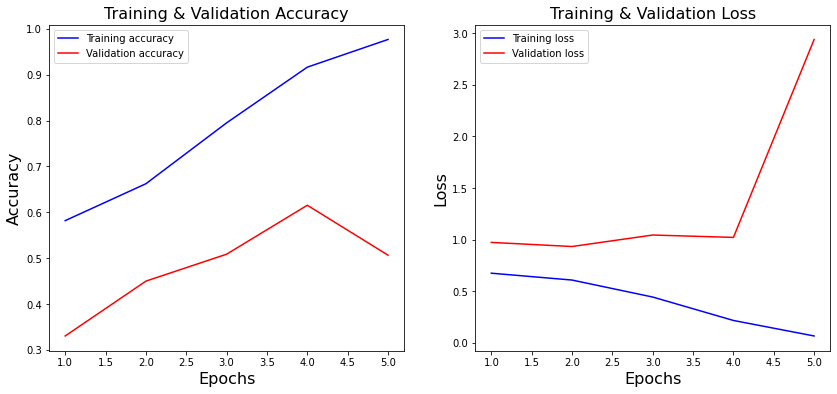

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva de a  the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

### Evaluación

In [ ]:
loss, accuracy = model.evaluate(encoded_test, y_test, batch_size=batch_size)


273/273 [==============================] - 1s 5ms/step - loss: 1.8812 - accuracy: 0.6401


También podemos hacer la evaluación usando las función **classification_report** que nos dará más información sobre los resultados para cada clase:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report 
y_pred = np.round(model.predict(encoded_test))

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

137/137 [==============================] - 1s 4ms/step
accuracy: 0.6401098901098901
              precision    recall  f1-score   support

  non-sexist       0.59      0.79      0.68      2087
      sexist       0.72      0.51      0.59      2281

    accuracy                           0.64      4368
   macro avg       0.66      0.65      0.64      4368
weighted avg       0.66      0.64      0.63      4368



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1644  443]
 [1129 1152]]


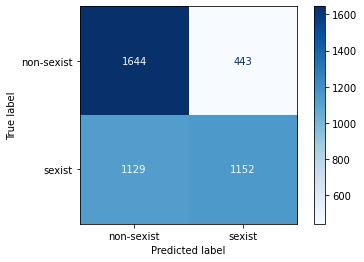

In [ ]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues,values_format='g')


## Discusión

- Respecto a los resultados por clase, ¿qué clase obtiene mejores resultados?
- ¿Qué nos dice la matriz de confusion?


## Ejercicio:

Entrena la red usando una modelo de word embedding de tamaño y dimension mayores, por ejemplo, **word2vec-google-news-300**, ¿qué ocurre?, ¿mejoran los resultados?